In [2]:
# Import Required Libraries
import pandas as pd
import math
import numpy as np

# ---------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import pylab 
plt.rcParams['figure.figsize']=(17,5)

# ---------------------------------------
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot

# ---------------------------------------
from prophet import Prophet
import holidays
from prophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

C:\Users\Arcega\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [3]:
# Functions 
def line_plot(df, date, AEP, text, y_tiltle, x_title):
    data = go.Scatter(x = df[date],
                      y = df[AEP],
                      mode = 'lines',
                      name = AEP)

    layout = go.Layout(title={'text': text,
                              'y':0.9,
                              'x':0.5,
                              'xanchor': 'center',
                              'yanchor': 'top'},
                       xaxis = dict(title = x_title),
                       yaxis = dict(title = y_tiltle),
                       template = 'plotly_dark')

    fig = go.Figure(data = data, layout = layout)
    iplot(fig)
    
# ---------------------------------------
def new_df(df, col, new_date, new_AEP, split):
    tmp_df = df[[col]].reset_index().rename(columns={'Datetime':new_date, 'Entry':new_AEP})
    tmp_df = pd.DataFrame(tmp_df.resample(split, on='Datetime', origin = 'start').mean())
    tmp_df.reset_index(inplace=True)
    return tmp_df

# ---------------------------------------
def bar_plot(col1, col2, agg_func, title, xtitle, ytitle):
    data = go.Bar(x = df.groupby(col1).agg({col2: agg_func}). \
              reset_index()[col1],
              y = df.groupby(col1).agg({col2: agg_func}). \
              reset_index()[col2],
              text =round(df.groupby(col1).agg({col2: agg_func}).reset_index()[col2],2),
              textposition= 'outside')

    layout = go.Layout(title={'text': title,
                              'y':0.9,
                              'x':0.5,
                              'xanchor': 'center',
                              'yanchor': 'top'},
                       xaxis = dict(title = xtitle),
                       yaxis = dict(title = ytitle),
                       template = 'plotly_dark')

    fig = go.Figure(data = data, layout = layout)
    iplot(fig)


# ---------------------------------------
def box_plot(q_num, col1, col2, color, title, xtitle, ytitle):
    box = go.Box(x = df.loc[df['quarter']==q_num][col1],
                       y = df.loc[df['quarter']==q_num][col2],
                       name = col1, 
                       marker_color= color)

    layout = go.Layout(title={'text': title,
                              'y':0.9,
                              'x':0.5,
                              'xanchor': 'center',
                              'yanchor': 'top'},
                       xaxis = dict(title = xtitle),
                       yaxis = dict(title = ytitle),
                       template = 'plotly_dark')


    fig = go.Figure(data = box, layout = layout)
    iplot(fig)


# ---------------------------------------
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [4]:
df = pd.read_csv('data/00_MRT_Prophet2224.csv', index_col=[0], parse_dates=[0])
df.head

<bound method NDFrame.head of                      Entry
Datetime                  
2022-10-01 00:00:00      0
2022-10-01 01:00:00      0
2022-10-01 02:00:00      0
2022-10-01 03:00:00      0
2022-10-01 04:00:00      0
...                    ...
2024-01-31 19:00:00   3412
2024-01-31 20:00:00   2944
2024-01-31 21:00:00   2111
2024-01-31 22:00:00     64
2024-01-31 23:00:00      0

[11712 rows x 1 columns]>

In [5]:
df = df[['Entry']].reset_index().rename(columns={'Datetime':'ds', 'Entry':'y'})

# Assume df is your dataframe with a 'ds' (timestamp) column
# Extract the hour from the 'ds' column
df['hour'] = pd.to_datetime(df['ds']).dt.hour

# Define rush hours: 7-9 AM and 5-7 PM
df['rush_hour'] = df['hour'].apply(lambda x: 1 if (7 == x) else 0)
df['off_hour'] = df['hour'].apply(lambda x: 1 if (x >= 23) or (x <= 3) else 0)
df.head()

,ds,y,hour,rush_hour,off_hour
0,2022-10-01 00:00:00,0,0,0,1
1,2022-10-01 01:00:00,0,1,0,1
2,2022-10-01 02:00:00,0,2,0,1
3,2022-10-01 03:00:00,0,3,0,1
4,2022-10-01 04:00:00,0,4,0,0


In [6]:
train_len = math.floor((df.shape[0]*150)/160)
train = df[:train_len]
test = df[train_len:]

train.head()
test.head()

,ds,y,hour,rush_hour,off_hour
10980,2024-01-01 12:00:00,2271,12,0,0
10981,2024-01-01 13:00:00,2130,13,0,0
10982,2024-01-01 14:00:00,2152,14,0,0
10983,2024-01-01 15:00:00,2649,15,0,0
10984,2024-01-01 16:00:00,2596,16,0,0


In [7]:
train_samples = go.Scatter(x = train['ds'],
                  y = train['y'],
                  mode = 'lines',
                  name = 'Train')

test_samples = go.Scatter(x = test['ds'],
                  y = test['y'],
                  mode = 'lines',
                  name = 'Test')

layout = go.Layout(title={'text': 'Train/test split',
                          'y':0.9,
                          'x':0.5,
                          'xanchor': 'center',
                          'yanchor': 'top'},
                   xaxis = dict(title = 'Year'),
                   yaxis = dict(title = 'Entry'),
                   template = 'plotly_dark')

data = [train_samples, test_samples]
fig = go.Figure(data = data, layout = layout)
iplot(fig)

In [8]:
holiday = pd.DataFrame([])
for date, name in sorted(holidays.Philippines(years=[2022, 2023, 2024]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': name}, index=[0])], ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

holiday.head(10)


,ds,holiday
0,2022-01-01,New Year's Day
1,2022-02-01,Chinese New Year
2,2022-02-25,EDSA Revolution Anniversary
3,2022-04-09,Day of Valor
4,2022-04-14,Maundy Thursday
5,2022-04-15,Good Friday
6,2022-04-16,Black Saturday
7,2022-05-01,Labour Day
8,2022-05-02,Eid'l Fitr (estimated)
9,2022-06-12,Independence Day


In [42]:
# Initialize the Prophet model

m = Prophet(
    yearly_seasonality=True,
    daily_seasonality=True,
    weekly_seasonality=True,
    holidays=holiday,
    seasonality_mode='multiplicative',
    seasonality_prior_scale = 1.0,
    changepoint_prior_scale= 0.01,
)
m.add_regressor('rush_hour', prior_scale=10)

# Fit the model on the training data
m.fit(train)

00:27:33 - cmdstanpy - INFO - Chain [1] start processing
00:27:37 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
test_forecast = m.predict(test)
test_forecast['hour'] = pd.to_datetime(test_forecast['ds']).dt.hour
test_forecast['yhat'] = test_forecast['yhat'].apply(lambda x: max(x, 0))
test_forecast['yhat_lower'] = test_forecast['yhat_lower'].apply(lambda x: max(x, 0))
test_forecast['yhat'] = test_forecast['yhat'].round()
test_forecast.loc[(test_forecast['hour'] >= 23) | (test_forecast['hour'] <= 3), 'yhat'] = 0
test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2024-01-01 12:00:00,2205.0,1541.571424,2936.635222
1,2024-01-01 13:00:00,2333.0,1637.526810,3072.566095
2,2024-01-01 14:00:00,2310.0,1624.072665,3051.520038
3,2024-01-01 15:00:00,2308.0,1623.493871,2988.290416
4,2024-01-01 16:00:00,2563.0,1893.354171,3261.461456


In [44]:
# Create a future DataFrame with hourly intervals for the desired forecast period
future = m.make_future_dataframe(periods=30, freq='D')
# Extract the hour for the future periods
future['hour'] = pd.to_datetime(future['ds']).dt.hour

# Apply rush hour condition to future data
future['rush_hour'] = future['hour'].apply(lambda x: 1 if (7 == x) else 0)
future['off_hour'] = future['hour'].apply(lambda x: 1 if (x >= 23) or (x <= 3) else 0)


# Make predictions
forecast = m.predict(future)
forecast['hour'] = pd.to_datetime(forecast['ds']).dt.hour
forecast['yhat'] = forecast['yhat'].apply(lambda x: max(x, 0))
forecast['yhat_lower'] = forecast['yhat_lower'].apply(lambda x: max(x, 0))
forecast['yhat_upper'] = forecast['yhat_upper'].apply(lambda x: max(x, 0))
forecast['yhat'] = forecast['yhat'].round()
forecast.loc[(forecast['hour'] >= 23) | (forecast['hour'] <= 3), 'yhat'] = 0
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2022-10-01 00:00:00,0.0,0.0,754.707688
1,2022-10-01 01:00:00,0.0,0.0,677.097338
2,2022-10-01 02:00:00,0.0,0.0,512.191193
3,2022-10-01 03:00:00,0.0,0.0,644.200300
4,2022-10-01 04:00:00,491.0,0.0,1215.011850


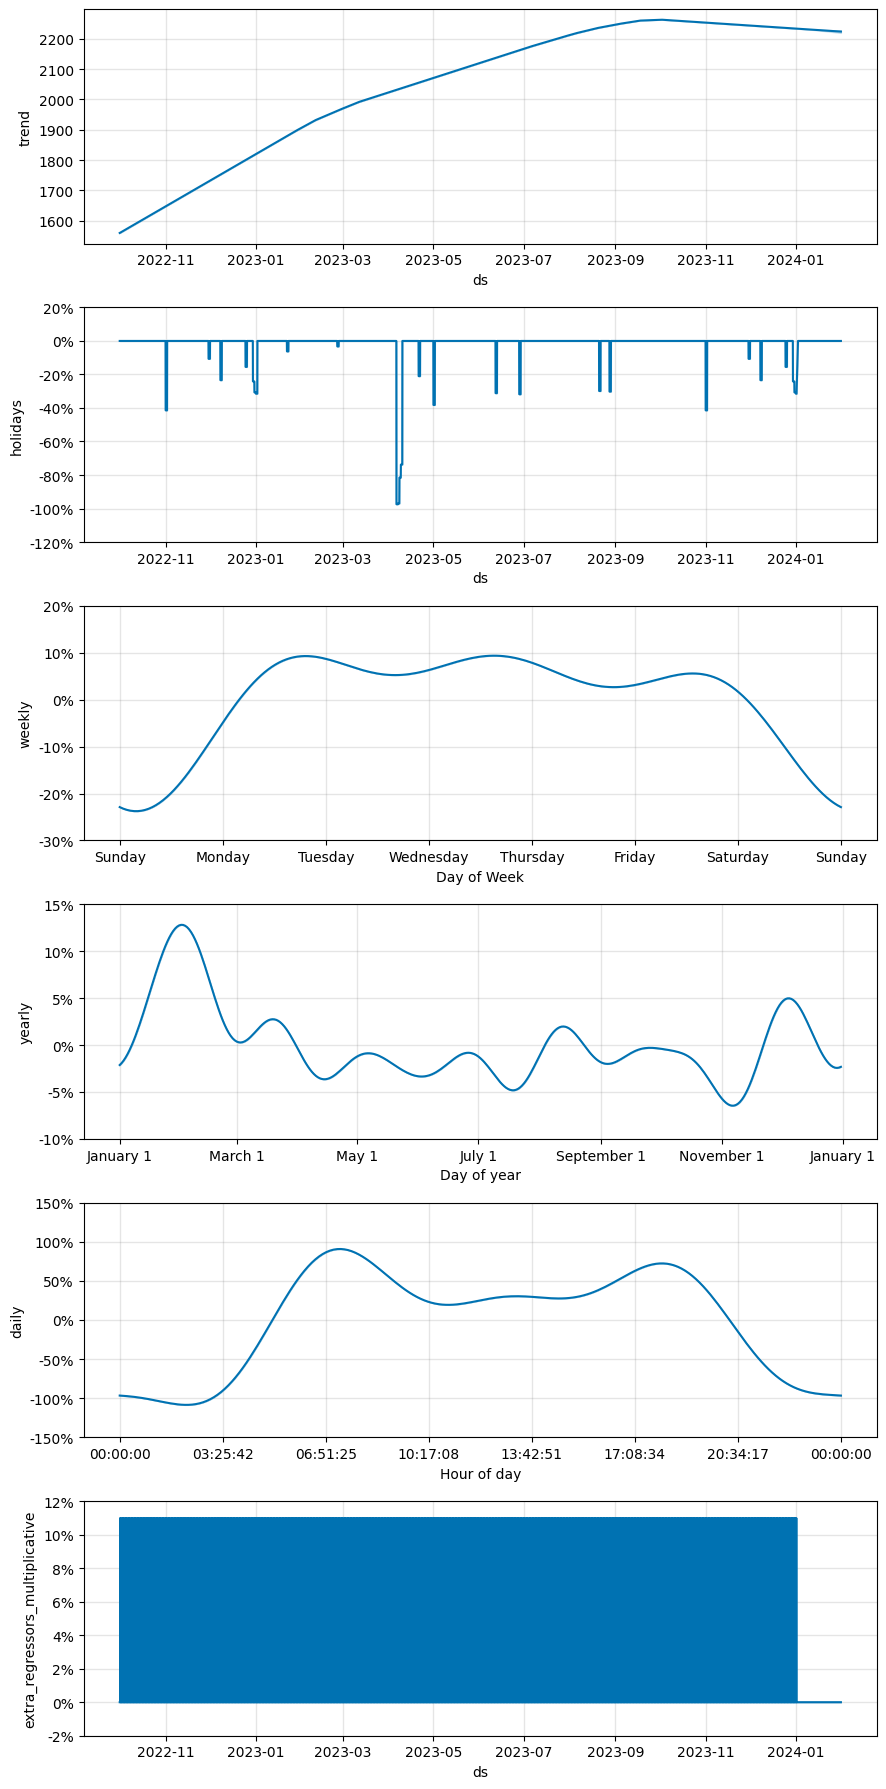

In [45]:
fig = m.plot_components(forecast)

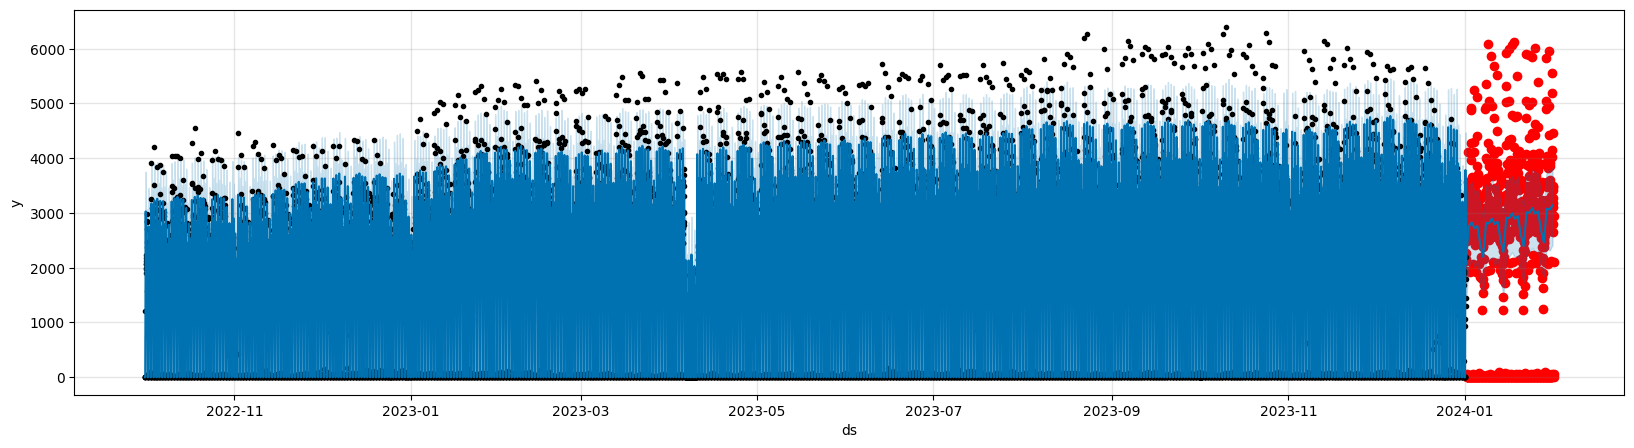

In [58]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(20)
ax.scatter(test.ds, test['y'], color='r')
fig = m.plot(forecast,ax=ax)
plt.show()

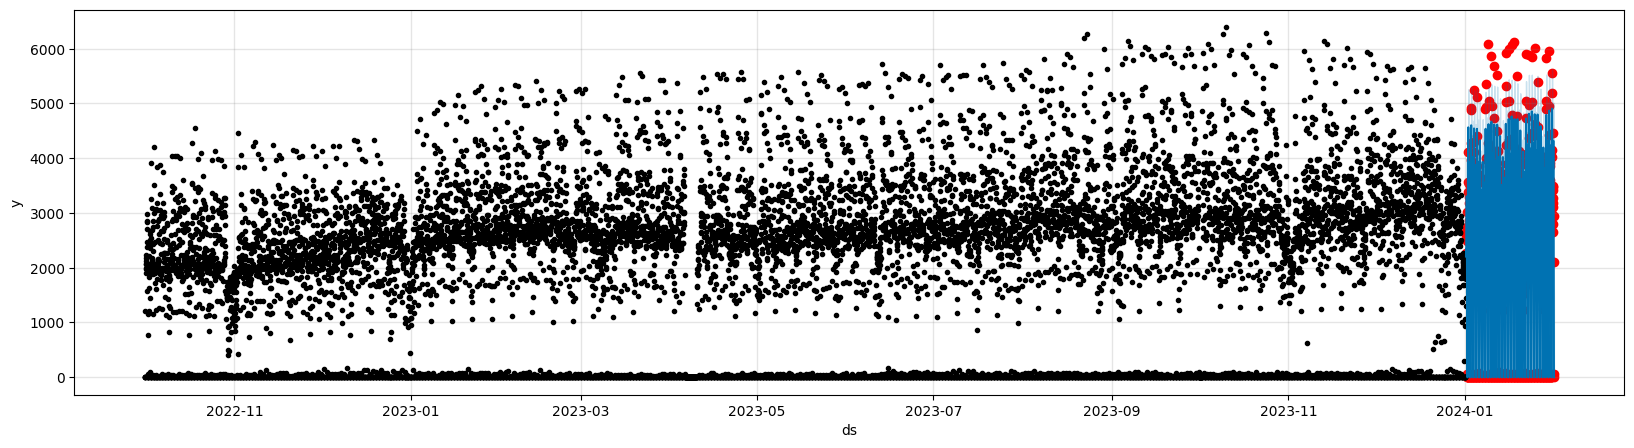

In [57]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(20)
ax.scatter(test.ds, test['y'], color='r')
fig = m.plot(test_forecast, ax=ax)

In [48]:
df_cv = cross_validation(m, horizon='30 days', parallel="processes")

df_cv.head()


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2023-10-03 12:00:00,2896.019416,2230.819459,3572.912462,2620,2023-10-03 11:00:00
1,2023-10-03 13:00:00,3016.772470,2339.070888,3665.508680,2600,2023-10-03 11:00:00
2,2023-10-03 14:00:00,2979.612757,2280.244262,3663.600694,2503,2023-10-03 11:00:00
3,2023-10-03 15:00:00,2965.614425,2334.468633,3627.148369,2645,2023-10-03 11:00:00
4,2023-10-03 16:00:00,3222.858782,2606.261361,3919.473310,3258,2023-10-03 11:00:00


In [49]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mdape,smape,coverage
0,3 days 00:00:00,309831.575157,556.625166,415.575300,0.186286,0.676257,0.811111
1,3 days 01:00:00,308207.182156,555.164104,413.910346,0.184235,0.675625,0.811111
2,3 days 02:00:00,307160.946036,554.221026,412.710417,0.184235,0.675131,0.811111
3,3 days 03:00:00,305810.379633,553.001247,411.042569,0.178901,0.674477,0.811111
4,3 days 04:00:00,306540.768461,553.661240,411.458136,0.184235,0.674644,0.811111


In [51]:
mse = mean_squared_error(y_true=test['y'],  y_pred=test_forecast['yhat'])
rmse = np.sqrt(mean_squared_error(y_true=test['y'], y_pred=test_forecast['yhat']))
mae = mean_absolute_error(y_true=test['y'], y_pred=test_forecast['yhat'])
r2 = r2_score(y_true=test['y'], y_pred=test_forecast['yhat'])
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R^2 Score: {r2}')

MSE: 271118.7704918033
RMSE: 520.6906667992075
MAE: 349.9535519125683
R^2 Score: 0.8969059946610469


In [52]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=test['y'],
                   y_pred=test_forecast['yhat'])

nan

In [53]:
mape_value = mape(test['y'], test_forecast['yhat'])
print(f"MAPE: {mape_value:.2f}%")
print(test)

MAPE: nan%
                       ds     y  hour  rush_hour  off_hour
10980 2024-01-01 12:00:00  2271    12          0         0
10981 2024-01-01 13:00:00  2130    13          0         0
10982 2024-01-01 14:00:00  2152    14          0         0
10983 2024-01-01 15:00:00  2649    15          0         0
10984 2024-01-01 16:00:00  2596    16          0         0
...                   ...   ...   ...        ...       ...
11707 2024-01-31 19:00:00  3412    19          0         0
11708 2024-01-31 20:00:00  2944    20          0         0
11709 2024-01-31 21:00:00  2111    21          0         0
11710 2024-01-31 22:00:00    64    22          0         0
11711 2024-01-31 23:00:00     0    23          0         1

[732 rows x 5 columns]


In [54]:
train_samples = go.Scatter(x = test_forecast['ds'],
                  y = test_forecast['yhat'],
                  mode = 'lines',
                  name = 'Train')
test_samples = go.Scatter(x = test['ds'],
                  y = test['y'],
                  mode = 'lines',
                  name = 'Test')

layout = go.Layout(title={'text': 'Actuals vs Forecast',
                          'y':0.9,
                          'x':0.5,
                          'xanchor': 'center',
                          'yanchor': 'top'},
                   xaxis = dict(title = 'Year'),
                   yaxis = dict(title = 'Entry'),
                   template = 'plotly_dark')

data = [train_samples, test_samples]
fig = go.Figure(data = data, layout = layout)
iplot(fig)

In [24]:
# Python
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

00:03:43 - cmdstanpy - INFO - Chain [1] start processing
00:03:44 - cmdstanpy - INFO - Chain [1] done processing
00:04:07 - cmdstanpy - INFO - Chain [1] start processing
00:04:09 - cmdstanpy - INFO - Chain [1] done processing
00:04:31 - cmdstanpy - INFO - Chain [1] start processing
00:04:33 - cmdstanpy - INFO - Chain [1] done processing
00:04:56 - cmdstanpy - INFO - Chain [1] start processing
00:04:57 - cmdstanpy - INFO - Chain [1] done processing
00:05:18 - cmdstanpy - INFO - Chain [1] start processing
00:05:20 - cmdstanpy - INFO - Chain [1] done processing
00:05:47 - cmdstanpy - INFO - Chain [1] start processing
00:05:49 - cmdstanpy - INFO - Chain [1] done processing
00:06:16 - cmdstanpy - INFO - Chain [1] start processing
00:06:18 - cmdstanpy - INFO - Chain [1] done processing
00:06:44 - cmdstanpy - INFO - Chain [1] start processing
00:06:45 - cmdstanpy - INFO - Chain [1] done processing
00:07:13 - cmdstanpy - INFO - Chain [1] start processing
00:07:18 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale        rmse
0                     0.001                     0.01  675.358674
1                     0.001                     0.10  664.683602
2                     0.001                     1.00  664.022062
3                     0.001                    10.00  663.325701
4                     0.010                     0.01  673.963221
5                     0.010                     0.10  662.163648
6                     0.010                     1.00  662.006944
7                     0.010                    10.00  662.168970
8                     0.100                     0.01  689.749126
9                     0.100                     0.10  679.829763
10                    0.100                     1.00  678.680801
11                    0.100                    10.00  680.188632
12                    0.500                     0.01  700.467684
13                    0.500                     0.10  690.916049
14                    0.5

In [25]:
# Python
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}


In [41]:
train_samples = go.Scatter(x = forecast['ds'],
                  y = forecast['yhat'],
                  mode = 'lines',
                  name = 'Train')
test_samples = go.Scatter(x = df['ds'],
                  y = df['y'],
                  mode = 'lines',
                  name = 'Actual')

layout = go.Layout(title={'text': 'Actuals vs Forecast',
                          'y':0.9,
                          'x':0.5,
                          'xanchor': 'center',
                          'yanchor': 'top'},
                   xaxis = dict(title = 'Year'),
                   yaxis = dict(title = 'Entry'),
                   template = 'plotly_dark')

data = [train_samples, test_samples]
fig = go.Figure(data = data, layout = layout)
iplot(fig)